# BOOM: Tephrochronology dataset of the Southern and Austral volcanic zones of the Andes.

### Machine Learning analysis

In this notebook we will test the use of machine learning classification algorithms (K- Nearest Neighbors (KNN), Random Forest (RF), Logistic Regression (LR), Gradient Boosting (GB)) to predict the volcanic source of a unclassified tephra deposits, based in their geochemistry. First, we define de target values and relevant information for the machine learning, then different combinations of classification algorithms and imputing mechanisms for the missing data are fited and evaluated, through a 5-fold cross validation with GridSearch. 

We test the classification algorithms using only major elements and with major and trace elements.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import sys
import time
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, GroupShuffleSplit
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import missingno as msno

In [2]:
sys.path.insert(1, '../Scripts')
from functions import preprocessing
from functions import GridSearchCV_with_groups
from functions import plot_scatterplots
from functions import plot_confusion_matrix

## 0. Load data

In [3]:
import pandas as pd
import requests
from io import StringIO

#Download the dataset from the ESPRI server as .csv 
url = "https://data.ipsl.fr/repository/TephraDatabase/TephraDataBase.csv"
s=requests.get(url).text
df = pd.read_csv(StringIO(s), encoding="latin1", low_memory=False)

#in case the ESPRI server is down:
#df = pd.read_csv("..assets/Data/BOOMDataset.csv", encoding = 'UTF-8', low_memory =False )

# 1. Preprocess data

In [4]:
#preprocessing data. For more info on the preprocessing of data, the reader is reffered to the BOOMDataset_preprocessing notebook
df = preprocessing(df)

# 2. Define targets and features for different models. We will do two tests:

        i. Volcanoes as targets and major elements as features.
        ii.- Volcanoes as targets and major and trace elements as features.

In [5]:
df['Volcano'] = df['Volcano'].astype("category")
df['Event'] = df['Event'].astype("category")
df['SampleID'] = df['SampleID'].astype("category")

2.1 Filter samples for which volcano id is unknown

In [6]:
df_unknown_volcano = df.loc[df.Volcano == 'Unknown']
df_unknown_event = df.loc[df.Event == 'Unknown']

df_volcanoes = df.loc[df.Volcano != 'Unknown'].copy()
df_events = df.loc[(df.Volcano != 'Unknown') & (df.Event != 'Unknown')].copy()

2.2 Filtering data for which major elements has been analyzed.

In [13]:
df_volcanoes_major = df_volcanoes.dropna(axis='rows',subset=['SiO2']).copy()

In [14]:
n = df_volcanoes.shape[0]
print(f'We now have {n} observations left')

We now have 13436 observations left


2.3 Retrieve the geochemical data. FeO, Fe2O3 and FeO2O3T are dropped because FeOT is a different expression of the same element (Fe). P2O5 and Cl are also dropped because they are sporadically analyzed.

In [15]:
majors = ['SiO2_normalized', 'TiO2_normalized', 'Al2O3_normalized',
           'FeOT_normalized', #'FeO_normalized', 'Fe2O3_normalized', 'Fe2O3T_normalized',
          'MnO_normalized','MgO_normalized', 'CaO_normalized', 'Na2O_normalized',
          'K2O_normalized', #'P2O5_normalized','Cl_normalized'
         ] 

X_major_volcanoes = df_volcanoes.loc[:, majors]
X_onlymajor_volcanoes = df_volcanoes_major.loc[:, majors]
X_major_events = df_events.loc[:, majors] 

traces = ['Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Cs', 'Ba', 'La',
          'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy',
          'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'Pb',
          'Th', 'U']

X_traces_volcanoes = df_volcanoes.loc[:, traces]
X_traces_events = df_events.loc[:, traces] 

X_volcanoes = pd.concat([X_major_volcanoes, X_traces_volcanoes], axis=1)
X_events = pd.concat([X_major_events, X_traces_events], axis=1)

2.4 Define target attributes (volcano and events) and list of SampleIDs to consider in the split train/test sets.

In [16]:
df['Volcano'] = df['Volcano'].astype("category")
df['Event'] = df['Event'].astype("category")
df['SampleID'] = df['SampleID'].astype("category")

yv = np.array(df_volcanoes['Volcano'].cat.codes, dtype='int8')
SampleID_volcanoes = np.array(df_volcanoes['SampleID'].cat.codes)

yv_major= np.array(df_volcanoes_major['Volcano'].cat.codes, dtype='int8')
SampleID_volcanoes_major = np.array(df_volcanoes_major['SampleID'].cat.codes)

ye = np.array(df_events['Event'].cat.codes, dtype='int8')
SampleID_events = np.array(df_events['SampleID'].cat.codes)

In [17]:
unique, counts = np.unique(SampleID_volcanoes, return_counts=True)
n_sampleID = len(counts)
print(f'There are {n_sampleID} sampleIDs')

There are 2048 sampleIDs


# 3. After all this treatment, we will check the target values and the missingness of the data

id: 0, volcán: Aguilera, sample observations: 40
id: 1, volcán: Antillanca-Casablanca, sample observations: 223
id: 2, volcán: Apagado, sample observations: 44
id: 3, volcán: Caburga-Huelemolle, sample observations: 134
id: 4, volcán: Calbuco, sample observations: 158
id: 5, volcán: Carrán-Los Venados, sample observations: 115
id: 6, volcán: Chaitén, sample observations: 2129
id: 7, volcán: Hornopirén, sample observations: 26
id: 8, volcán: Huanquihue Group, sample observations: 176
id: 9, volcán: Hudson, sample observations: 796
id: 10, volcán: Huequi, sample observations: 11
id: 11, volcán: Lanín, sample observations: 71
id: 12, volcán: Lautaro, sample observations: 37
id: 13, volcán: Llaima, sample observations: 1300
id: 14, volcán: Macá, sample observations: 12
id: 15, volcán: Melimoyu, sample observations: 456
id: 16, volcán: Mentolat, sample observations: 89
id: 17, volcán: Michinmahuida, sample observations: 569
id: 18, volcán: Mocho-Choshuenco, sample observations: 2598
id: 19,

SiO2_normalized     17.94
TiO2_normalized     17.94
Al2O3_normalized    17.94
FeOT_normalized     18.32
MnO_normalized      21.22
MgO_normalized      17.94
CaO_normalized      17.94
Na2O_normalized     17.94
K2O_normalized      17.94
Rb                  75.83
Sr                  74.58
Y                   75.71
Zr                  74.73
Nb                  76.59
Cs                  79.33
Ba                  76.03
La                  76.55
Ce                  76.60
Pr                  78.65
Nd                  76.69
Sm                  77.52
Eu                  78.04
Gd                  78.51
Tb                  77.96
Dy                  78.38
Ho                  78.65
Er                  78.48
Tm                  78.92
Yb                  77.52
Lu                  77.90
Hf                  77.98
Ta                  80.52
Pb                  77.77
Th                  77.46
U                   78.01
dtype: float64

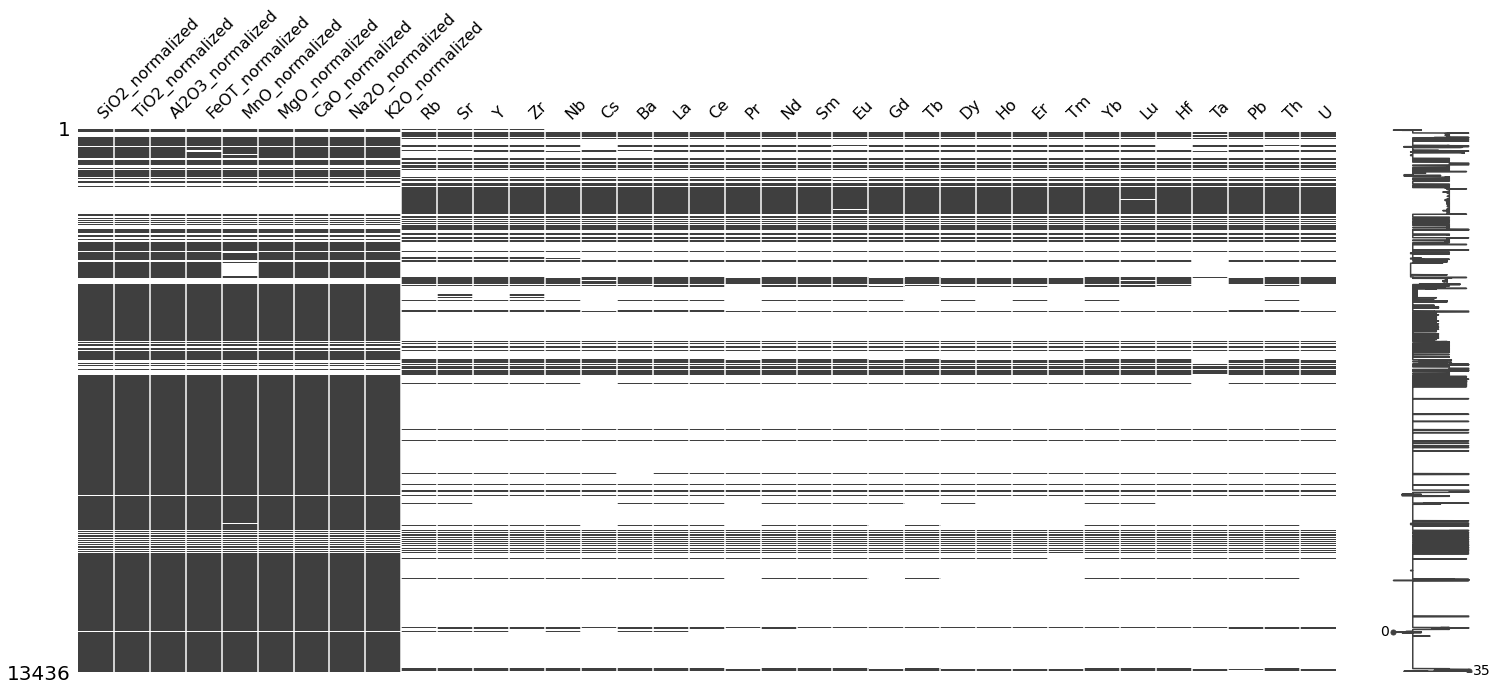

In [23]:
import numpy as np
# Understanding data
# Print number of sample observations per class
unique, counts = np.unique(yv, return_counts=True)
for u, c in zip(unique, counts):
    print('id: {}, volcán: \033[1m{}\033[0m, sample observations: {}'.format(u,df_volcanoes['Volcano'].cat.categories[u],c))

n_classes = len(unique)

import missingno as msno
msno.matrix(X_volcanoes)

print('Percentage of missing values for each elements')
X_volcanoes.isna().mean().round(4) * 100

# 4. We define the different models to be trained and the imputing algorithms.

4.1 Models

In [28]:
# K nearest neighbours
KNN = KNeighborsClassifier(n_neighbors=2,weights='distance')
grid_KNN = {'kneighborsclassifier__n_neighbors': [2, 5, 10],
            'kneighborsclassifier__weights': ['uniform', 'distance']}

In [29]:
# Multinomial logistic regression / baselines peu-etre
LR = LogisticRegression(penalty='l2', multi_class='multinomial',
                         solver='saga', class_weight='balanced',max_iter=5000)
grid_LR = {'logisticregression__C': [1e-2, 1e-1, 1, 1e1, 1e2]}

In [30]:
# Random Forest
RF = RandomForestClassifier(
    n_estimators=120, min_samples_leaf=1,
    random_state=0, class_weight='balanced',bootstrap=False,verbose=0)
# min_samples_split=5,'balanced_subsample' usar bootstrap false o
# class weight balanced_subsample no tiene gran efecto!
grid_RF = {'randomforestclassifier__n_estimators': [50, 100, 125, 150],
        'randomforestclassifier__min_samples_leaf': [1, 2, 5]}

In [31]:
# Gradient Boosting
GB = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=1)
   
grid_GB = {'gradientboostingclassifier__n_estimators': [50, 100, 125, 150],
        'gradientboostingclassifier__min_samples_leaf': [1, 2, 5]}

4.2 Imputing algorithms

In [32]:
# KNN Imputer
KNN_imp = KNNImputer(n_neighbors=15,weights='distance')

In [33]:
# Iterative Imputer with Bayesian Ridge
BR_imp = IterativeImputer(random_state=0,min_value=0,max_iter = 1500,
                       estimator=BayesianRidge(),initial_strategy = 'most_frequent')#se puede obtener en paralelo una matriz con el missing indicator a partir del atributo "indicator_"

In [ ]:
# Iterative Imputer with Random Forest
Estimator = RandomForestRegressor(random_state=0,n_estimators=120, min_samples_leaf=3)
RF_imp = IterativeImputer(random_state=0,estimator = Estimator,verbose=1,
                        min_value = 0,max_iter = 100)#se puede obtener en paralelo una matriz con el missing indicator a partir del atributo "indicator_"

In [ ]:
# Simple Imputer
S_imp = SimpleImputer(strategy = 'mean')

# 5. Fit models and evaluate them

Run grid search with groups nested in a 5 fold cross validation

In [ ]:
models = [RF]# KNN, LR, RF, GB 
models_grids = [grid_RF]# grid_KNN, grid_LR, grid_RF, grid_GB
imputings = [BR_imp]# KNN_imp, BR_imp, RF_imp, S_imp 

for i, model in enumerate(models):
    print(model)
    grid_model = models_grids[i]
    print(grid_model)
        
    for j, imp in enumerate(imputings):
        print(imp)
        
        clf = make_pipeline(imp, StandardScaler(), model)
        
        est = GridSearchCV_with_groups(clf, grid_model, cv_test_size=0.2, cv_n_splits=5,  n_jobs=3)
        
        gss = GroupShuffleSplit(test_size=.20, n_splits=5, random_state=0)
        
        cv = cross_validate(est,
                              X_volcanoes,
                              yv,
                              groups=SampleID_volcanoes,
                              scoring=['accuracy', 'balanced_accuracy'],
                              fit_params={'groups':SampleID_volcanoes},
                              cv=gss, 
                              n_jobs = 3)

        # Now we fit the GridSearchCV_with_groups in order to obtain the best params for each imputing-model pair
        # The same fit will be used to plot the classification in scatter plots, the confusion matrix and to obtaine the 
        # permutation importance.
        # !! Chiara, this is how I had solved the need for fitting a model, you can evaluate if you think is good or not or 
        #    do it as we said
        train_out, test_out = next(gss.split(X_volcanoes, groups=SampleID_volcanoes))
        X_test_out = X_volcanoes.iloc[test_out]; X_train_out = X_volcanoes.iloc[train_out]
        yv_test_out = yv[test_out]; yv_train_out= yv[train_out]
        groups_train_out = SampleID_volcanoes[train_out]
        est.fit(X_train_out, yv_train_out, groups_train_out) #should this be runned in a test set?
        pred = est.predict(X_test_out)

        # save run information
        save_runs = pd.DataFrame(columns=['Model','Imputing','fit_time','score_time','test_accuracy','test_balanced_accuracy'])

        for col in save_runs.columns:
            if col != 'Model' and col !='Imputing':
                save_runs.loc[0,col] =cv[col][0]
            if col == 'Model':
                save_runs.loc[0,col] = np.array(list(est.best_params_.items()))
            if col == 'Imputing':
                save_runs.loc[0,col] = imp
               
        # plot imputing and classification in different scatter plots in order to have an idea of which samples are
        # badly classified
        volcano_list = df.Volcano.cat.categories
        plot_scatterplots(X_volcanoes, yv, X_test_out, yv_test_out,
                          'SiO2_normalized', 'K2O_normalized',
                          est, pred, volcano_list, name= str(i)+str(j), save= 'yes')
        plot_scatterplots(X_volcanoes, yv, X_test_out, yv_test_out,
                          'SiO2_normalized', 'La',
                          est, pred, volcano_list, name= str(i)+str(j), save= 'yes')
        plot_scatterplots(X_volcanoes, yv, X_test_out, yv_test_out,
                          'Rb', 'Sr',
                          est, pred, volcano_list, name= str(i)+str(j), save= 'yes')
        plot_scatterplots(X_volcanoes, yv, X_test_out, yv_test_out,
                          'Cs', 'La',
                          est, pred, volcano_list, name= str(i)+str(j), save= 'yes')
        
        #plot the confusion matrix
        volcanoes_by_latitude = np.asarray(['Llaima','Sollipulli','Caburga-Huelemolle','Villarrica','Quetrupillán','Lanín',
                'Huanquihue Group','Mocho-Choshuenco','Carrán-Los Venados','Puyehue-Cordón Caulle',
                'Antillanca-Casablanca', 'Osorno','Calbuco','Yate','Apagado','Hornopirén','Huequi',
                'Michinmahuida','Chaitén','Corcovado', 'Yanteles','Melimoyu','Mentolat','Cay'
                'Macá','Hudson', 'Lautaro','Viedma','Aguilera','Reclus','Monte Burney'])

        yv_test_names = df.Volcano.cat.categories[yv_test_out]
        yv_pred_names = df.Volcano.cat.categories[pred]

        plot_confusion_matrix(yv_test_names, yv_pred_names, labels=volcanoes_by_latitude, name= 'ConfusionMatrix'+str(i)+str(j), save= 'yes')

        # plot permutation importance
        result = permutation_importance(est.best_estimator_, X_test_out, yv_test_out, 
                                        n_repeats=10, random_state=42, n_jobs=3)
        sorted_idx = result.importances_mean.argsort()

        fig, ax = plt.subplots(figsize=(8,8))
        ax.boxplot(
        result.importances[sorted_idx].T, vert=False,
        labels=X_test_out.columns[sorted_idx])
        ax.set_title("Permutation Importances (test set)")
        fig.tight_layout()
        plt.savefig('../Plots/'+'permutation_importance_'+str(i)+str(j)+'.png',dpi = 300,bbox_inches='tight')
        plt.show()
        
save_runs.to_csv("runs_info.csv")